In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
from matplotlib.backends.backend_pdf import PdfPages


## Display Options ##
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Data
year_1 = pd.read_csv('year1.csv')
year_2 = pd.read_csv('year2.csv')
year_3 = pd.read_csv('year3.csv')

# Combining Years 1 and 2 Data
data = pd.concat([year_1, year_2], ignore_index=True)

Feature Engineering

In [3]:
# Define descriptions that indicate a swing
swing_descriptions = [
    'swinging_strike', 'foul', 'hit_into_play', 
    'swinging_strike_blocked', 'foul_tip', 'missed_bunt'
]

# Create a new column 'swing' that marks whether the pitch resulted in a swing
data['swing'] = data['description'].isin(swing_descriptions).astype(int)

In [4]:
# Define strike zone height and width features
data['strike_zone_height'] = data['sz_top'] - data['sz_bot']
data['strike_zone_width'] = 1.417
data['plate_dist_center'] = np.sqrt(data['plate_x']**2 + data['plate_z']**2)

In [5]:
# Identify categorical columns
categorical_cols = ['pitch_type', 'stand', 'p_throws']

# One-hot encode categorical variables
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_encoded = onehot.fit_transform(data[categorical_cols])

# Create a DataFrame with the one-hot encoded columns
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot.get_feature_names_out(categorical_cols))

# Drop original categorical columns and concatenate one-hot encoded columns
data = data.drop(columns=categorical_cols)
data = pd.concat([data, onehot_df], axis=1)

In [6]:
# Drop the 'description' column from the feature matrix
X = data.drop(columns=['swing', 'description'])
y = data['swing']

In [7]:
# Impute missing values using mean strategy
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Verify all columns in X are now numeric
assert X.applymap(np.isreal).all().all(), "Non-numeric columns found in feature matrix"

In [8]:
# Check the shapes of X and y to ensure correctness
print(X.shape, y.shape)

(1418392, 37) (1418392,)


In [9]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=3)

# Train a Random Forest Classifier
# uncomment to run

#model = RandomForestClassifier(n_estimators=500, random_state=3)
#model.fit(X_train, y_train)

In [10]:
#Load the saved trained model, imputer, and one-hot encoder
%pip install joblib 
from joblib import dump, load

model = load('random_forest_model.joblib')
imputer = load('imputer.joblib')
onehot = load('onehot.joblib')


Note: you may need to restart the kernel to use updated packages.


In [11]:
# Evaluate the model
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f'Accuracy: {accuracy:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

Accuracy: 0.8936
ROC-AUC: 0.9636


Year 3

In [12]:
# Load the trained model, imputer, and one-hot encoder
model = load('random_forest_model.joblib')
imputer = load('imputer.joblib')
onehot = load('onehot.joblib')

# Load the original year_3 DataFrame
year_3 = pd.read_csv('year3.csv')

# Feature engineering for year_3
year_3['strike_zone_height'] = year_3['sz_top'] - year_3['sz_bot']
year_3['strike_zone_width'] = 1.417 
year_3['plate_dist_center'] = np.sqrt(year_3['plate_x']**2 + year_3['plate_z']**2)

# One-hot encode categorical variables without dropping original columns
categorical_cols = ['pitch_type', 'stand', 'p_throws']
onehot_encoded = onehot.transform(year_3[categorical_cols])
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot.get_feature_names_out(categorical_cols))

# Concatenate one-hot encoded columns
year_3_processed = pd.concat([year_3, onehot_df], axis=1)

# Ensure columns match between training and test data
missing_cols = [col for col in X.columns if col not in year_3_processed.columns]
for col in missing_cols:
    year_3_processed[col] = 0

# Reorder columns to match the training data
year_3_processed = year_3_processed[X.columns]

# Impute missing values using the same strategy
X_test = pd.DataFrame(imputer.transform(year_3_processed), columns=year_3_processed.columns)

# Predict swing probabilities
year_3_processed['SwingProbability'] = model.predict_proba(X_test)[:, 1]

# Drop one-hot encoded columns
year_3_processed_cleaned = year_3_processed.drop(columns=onehot.get_feature_names_out(categorical_cols))

# Merge with original year_3 DataFrame on pitch_id
year_3_final = pd.merge(year_3, year_3_processed_cleaned[['pitch_id', 'SwingProbability']], on='pitch_id', how='left')

# Save the cleaned DataFrame with original columns and SwingProbability
original_columns = ['season', 'pitch_id', 'release_speed', 'batter', 'pitcher', 'balls', 'strikes', 
                    'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'sz_top', 'sz_bot', 
                    'strike_zone_height', 'plate_dist_center', 'pitch_type', 
                    'stand', 'p_throws', 'SwingProbability']

# Select the required columns
year_3_cleaned = year_3_final[original_columns]

# Save to validation.csv
year_3_cleaned.to_csv('validation.csv', index=False)

print("Cleaned data with original columns and SwingProbability saved to validation.csv")

Cleaned data with original columns and SwingProbability saved to validation.csv


In [13]:
year_3_cleaned

,season,pitch_id,release_speed,batter,pitcher,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot,strike_zone_height,plate_dist_center,pitch_type,stand,p_throws,SwingProbability
0,3,4135978.000,78.800,5464,6936,1,1,1.110,0.300,-0.330,0.490,3.580,1.660,1.920,0.591,ST,L,R,0.320
1,3,4135989.000,93.700,5464,6936,2,2,-1.160,1.360,-1.570,2.490,3.580,1.690,1.890,2.944,FF,L,R,0.314
2,3,4135993.000,94.200,5464,6936,3,2,-1.240,1.260,-1.310,3.480,3.680,1.690,1.990,3.718,FF,L,R,0.358
3,3,4131576.000,91.200,6446,6727,0,0,-1.030,1.380,1.020,2.310,3.290,1.580,1.710,2.525,FF,R,R,0.150
4,3,4131602.000,84.500,5667,6727,3,2,0.200,0.120,0.610,1.360,3.410,1.630,1.780,1.491,SL,R,R,0.716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874640,3,3445407.000,86.900,7085,6260,1,2,-1.020,0.070,-0.550,1.760,3.150,1.480,1.670,1.844,FS,L,R,0.810
1874641,3,3445402.000,94.800,5674,6260,0,2,-0.910,0.960,-0.160,3.050,3.580,1.700,1.880,3.054,FF,L,R,0.830
1874642,3,3445412.000,78.500,5674,6260,1,2,1.040,-1.080,1.220,0.310,3.330,1.570,1.760,1.259,CU,L,R,0.174
1874643,3,3445414.000,94.400,5674,6260,2,2,-0.770,1.240,-0.690,3.220,3.580,1.700,1.880,3.293,FF,L,R,0.812


In [14]:
# Identify the batter with the most pitches thrown to them
most_pitches_batter = year_3_cleaned['batter'].value_counts().idxmax()
print(f"Batter with the most pitches thrown to : {most_pitches_batter}")

Batter with the most pitches thrown to : 6101


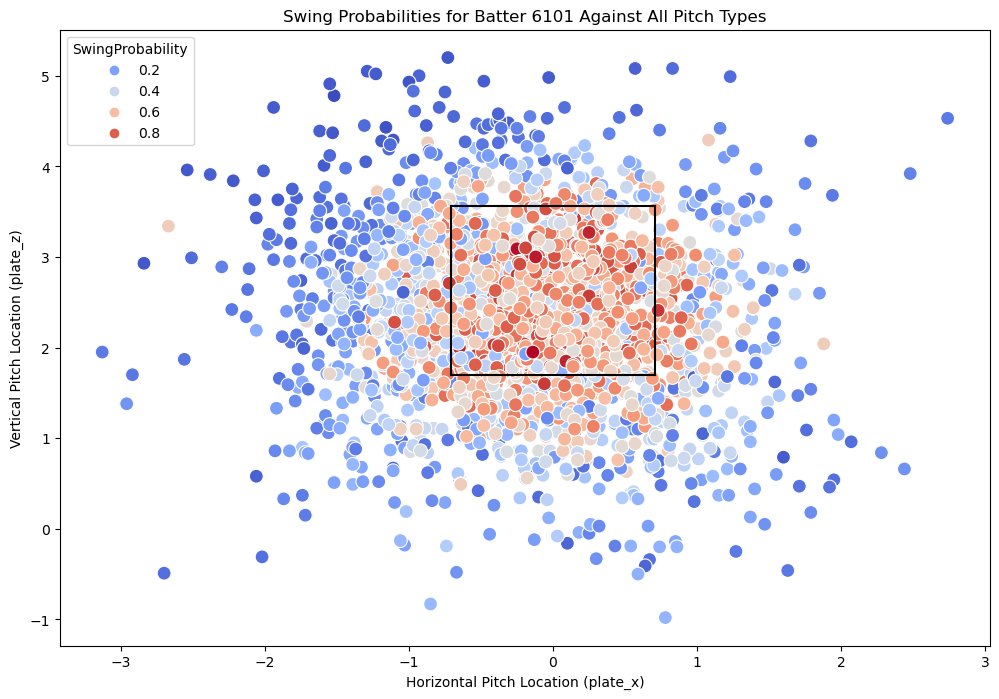

In [15]:
year_3_cleaned = pd.read_csv('validation.csv')

# Filter data for batter 6101
batter_id = 6101
filtered_data = year_3_cleaned[year_3_cleaned['batter'] == batter_id]

# Define the width of the strike zone in feet (17 inches = 1.417 feet)
strike_zone_width = 1.417

# Plotting swing probabilities against plate_x and plate_z for the filtered data
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=filtered_data, x='plate_x', y='plate_z', hue='SwingProbability', palette='coolwarm', s=100)

# Calculate mean strike zone top and bottom
sz_top = filtered_data['sz_top'].mean()
sz_bot = filtered_data['sz_bot'].mean()

# Define the strike zone box
plt.plot([-strike_zone_width / 2, strike_zone_width / 2], [sz_top, sz_top], color='black')
plt.plot([-strike_zone_width / 2, strike_zone_width / 2], [sz_bot, sz_bot], color='black')
plt.plot([-strike_zone_width / 2, -strike_zone_width / 2], [sz_bot, sz_top], color='black')
plt.plot([strike_zone_width / 2, strike_zone_width / 2], [sz_bot, sz_top], color='black')

plt.title(f'Swing Probabilities for Batter {batter_id} Against All Pitch Types')
plt.xlabel('Horizontal Pitch Location (plate_x)')
plt.ylabel('Vertical Pitch Location (plate_z)')

plt.show()

In [16]:
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches

# Load the final cleaned data
year_3_cleaned = pd.read_csv('validation.csv')

# Filter data for batter 6101
batter_id = 6101
filtered_data = year_3_cleaned[year_3_cleaned['batter'] == batter_id]

# Check if filtered data is not empty
print(f"Number of records for batter {batter_id}: {len(filtered_data)}")
if filtered_data.empty:
    print("No data found for the specified batter.")
    exit()

# Extract the batter's hitting hand
hitting_hand = filtered_data['stand'].iloc[0]  # Assume all rows for the same batter have the same 'stand' value

# Define the width of the strike zone in feet (17 inches = 1.417 feet)
strike_zone_width = 1.417

# Get the list of unique pitch types and pitcher handedness
pitch_types = filtered_data['pitch_type'].unique()
pitcher_handedness = filtered_data['p_throws'].unique()

# Define the fixed min and max swing probabilities for color coding
vmin = 0.15
vmax = 0.90

# Define the custom colorbar ticks
colorbar_ticks = [0.15, 0.30, 0.45, 0.60, 0.75, 0.90]

# Create a custom colormap and norm for the legend
cmap = sns.color_palette("coolwarm", as_cmap=True)
norm = BoundaryNorm(colorbar_ticks, ncolors=cmap.N, clip=True)

# Create a PdfPages object to save the plots
pdf_filename = 'swing_probabilities_plots.pdf'
pdf_pages = PdfPages(pdf_filename)

# Define the common limits for the axes
x_limits = (-2, 2)
y_limits = (0, 5)

# Create the legend patches
legend_patches = [mpatches.Patch(color=cmap(norm(tick)), label=f'{tick:.2f}') for tick in colorbar_ticks]

# Loop through each pitch type and pitcher handedness combination and create a plot
for pitch_type in pitch_types:
    for p_throw in pitcher_handedness:
        combo_data = filtered_data[(filtered_data['pitch_type'] == pitch_type) & (filtered_data['p_throws'] == p_throw)]
        
        print(f"Pitch type: {pitch_type}, Pitcher hand: {p_throw}, Number of records: {len(combo_data)}")
        
        if not combo_data.empty:  # Check if there are any data points to plot
            plt.figure(figsize=(12, 8))
            scatter = sns.scatterplot(data=combo_data, x='plate_x', y='plate_z', hue='SwingProbability', palette=cmap, s=100, norm=norm, edgecolor="none")
            
            # Calculate mean strike zone top and bottom
            sz_top = combo_data['sz_top'].mean()
            sz_bot = combo_data['sz_bot'].mean()
            
            # Define the strike zone box
            plt.plot([-strike_zone_width / 2, strike_zone_width / 2], [sz_top, sz_top], color='black')
            plt.plot([-strike_zone_width / 2, strike_zone_width / 2], [sz_bot, sz_bot], color='black')
            plt.plot([-strike_zone_width / 2, -strike_zone_width / 2], [sz_bot, sz_top], color='black')
            plt.plot([strike_zone_width / 2, strike_zone_width / 2], [sz_bot, sz_top], color='black')
            
            plt.title(f'Swing Probabilities for Batter {batter_id} ({hitting_hand}-Handed) Against {p_throw}-Handed {pitch_type} Pitches')
            plt.xlabel('Horizontal Pitch Location (plate_x)')
            plt.ylabel('Vertical Pitch Location (plate_z)')
            
            # Add custom legend
            plt.legend(handles=legend_patches, title="Swing Probability", bbox_to_anchor=(1.05, 1), loc='upper left')

            # Set the common limits for the axes
            plt.xlim(x_limits)
            plt.ylim(y_limits)
            
            # Adjust layout and save the current figure to the PDF
            plt.tight_layout()
            pdf_pages.savefig(bbox_inches='tight')
            plt.close()
        else:
            print(f"No data points for pitch type {pitch_type} and pitcher hand {p_throw}.")

pdf_pages.close()

print(f"Plots saved to {pdf_filename}")

Number of records for batter 6101: 33368
Pitch type: FF, Pitcher hand: L, Number of records: 251
Pitch type: FF, Pitcher hand: R, Number of records: 9160
Pitch type: SL, Pitcher hand: L, Number of records: 3369
Pitch type: SL, Pitcher hand: R, Number of records: 184
Pitch type: SI, Pitcher hand: L, Number of records: 5535
Pitch type: SI, Pitcher hand: R, Number of records: 2339
Pitch type: CH, Pitcher hand: L, Number of records: 18
Pitch type: CH, Pitcher hand: R, Number of records: 3418
Pitch type: KC, Pitcher hand: L, Number of records: 2
Pitch type: KC, Pitcher hand: R, Number of records: 26
Pitch type: ST, Pitcher hand: L, Number of records: 40
Pitch type: ST, Pitcher hand: R, Number of records: 26
Pitch type: CU, Pitcher hand: L, Number of records: 25
Pitch type: CU, Pitcher hand: R, Number of records: 1190
Pitch type: FC, Pitcher hand: L, Number of records: 1113
Pitch type: FC, Pitcher hand: R, Number of records: 6589
Pitch type: FS, Pitcher hand: L, Number of records: 0
No data 

In [21]:
# Load Season 2 data
season_2 = pd.read_csv('year2.csv')

# Define descriptions that indicate a swing
swing_descriptions = [
    'swinging_strike', 'foul', 'hit_into_play', 
    'swinging_strike_blocked', 'foul_tip', 'missed_bunt'
]

# Create a new column 'swing' that marks whether the pitch resulted in a swing
season_2['swing'] = season_2['description'].isin(swing_descriptions).astype(int)

# Verify the new 'swing' column
print(season_2[['description', 'swing']].head())

# Calculate league average swing probability
league_avg_swing_prob = season_2['swing'].mean()
print(f"League Average Swing Probability: {league_avg_swing_prob:.3f}")

# Calculate individual player swing probabilities
player_swing_probs = season_2.groupby('batter')['swing'].mean()

# Calculate SPAA
spaa = player_swing_probs - league_avg_swing_prob

# Check for any invalid SPAA values
print("SPAA value range:", spaa.min(), spaa.max())

# Top 10 players by SPAA
top_10_players = spaa.nlargest(10)
print("Top 10 Players by SPAA:")
print(top_10_players)

# Bottom 10 players by SPAA
bottom_10_players = spaa.nsmallest(10)
print("Bottom 10 Players by SPAA:")
print(bottom_10_players)

     description  swing
0           ball      0
1           ball      0
2           ball      0
3  called_strike      0
4  called_strike      0
League Average Swing Probability: 0.477
SPAA value range: -0.47728286335281 0.3004949144249678
Top 10 Players by SPAA:
batter
5240   0.300
6429   0.215
6561   0.189
5325   0.176
6210   0.173
6854   0.168
6831   0.159
7122   0.156
6039   0.155
6847   0.151
Name: swing, dtype: float64
Bottom 10 Players by SPAA:
batter
5803   -0.477
5890   -0.477
6783   -0.227
7057   -0.201
6497   -0.183
6274   -0.170
7042   -0.161
5696   -0.160
5569   -0.156
5376   -0.144
Name: swing, dtype: float64
